In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer
from mpl_toolkits import mplot3d

In [111]:
pd.set_option('display.max_columns', None)
X = pd.read_csv('../../../data/trainingsetvalues.csv')
y = pd.read_csv('../../../data/trainingsetlabels.csv')

In [112]:
X.funder = X.funder.replace(np.nan, 'Unknown')
X.installer = X.installer.replace(np.nan, 'Unknown')
X.permit = X.permit.replace(np.nan, False)

In [113]:
y = y.drop(columns = 'id')

In [114]:
y.status_group.loc[y.status_group == 'functional'] = 1
y.status_group.loc[y.status_group != 1] = 0
y = y.astype(int)

In [115]:
droplist = ['wpt_name', 'subvillage', 'num_private', 'scheme_name', 'recorded_by', 'scheme_management', 'management', 'extraction_type', 
            'payment', 'extraction_type_class', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'ward',
           'region_code', 'district_code', 'public_meeting', 'funder', 'lga', 'management_group']

X_clean = X.drop(columns = droplist, axis=1)

# Created a new age column

In [116]:
years = [int(X_clean['date_recorded'][x][:4]) for x in range(len(X_clean['date_recorded']))]
X_clean['date_recorded'] = years

In [117]:
X_clean.construction_year = X_clean.construction_year.replace(0, 2000)

In [118]:
X_clean['age'] = X_clean['date_recorded'] - X_clean['construction_year']

# Cleaned up the Installer Column

In [119]:
top_installers = list(X_clean.installer.value_counts()[:7].index)
top_installers

['DWE', 'Unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT']

In [120]:
X_clean.installer.loc[~X_clean['installer'].isin(top_installers)] = 'Other'

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Filled in Zero's for the gps_height column

In [121]:
dodoma_idx = X_clean[X_clean.region == 'Dodoma'].index
X_clean.at[dodoma_idx, 'gps_height'] = 1350

In [122]:
kagera_idx = X_clean[X_clean.region == 'Kagera'].index
X_clean.at[kagera_idx, 'gps_height'] = 1450

In [123]:
mbeya_idx = X_clean[X_clean.region == 'Mbeya'].index
X_clean.at[mbeya_idx, 'gps_height'] = 1715

In [124]:
tabora_idx = X_clean[X_clean.region == 'Tabora'].index
X_clean.at[tabora_idx, 'gps_height'] = 1200

In [125]:
shinyanga_idx = X_clean[X_clean.region == 'Shinyanga'].index
X_clean.at[shinyanga_idx, 'gps_height'] = 1162

In [126]:
mwanza_idx = X_clean[X_clean.region == 'Mwanza'].index
X_clean.at[mwanza_idx, 'gps_height'] = 1200

# Made a function for returning catagorical and numerical columns

In [127]:
def cleaning(data):
    cat_cols = list(data.select_dtypes('object'))
    numeric_cols = list(data.select_dtypes('number'))
    cat_df = pd.DataFrame(data[cat_cols])
    numeric_df = pd.DataFrame(data[numeric_cols])
    return cat_df, numeric_df

# Split into categorical and numerical

In [128]:
X_cats, X_nums = cleaning(X_clean)
X_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)

# One hot encoder and scaler

In [129]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_cats)
X_cats_ohe = pd.DataFrame(ohe.transform(X_cats), columns = ohe.get_feature_names(input_features = X_cats.columns))

In [130]:
ss = StandardScaler()
ss.fit(X_nums)
X_nums_scaled = pd.DataFrame(ss.transform(X_nums), columns = X_nums.columns)

In [131]:
X_data = pd.concat((X_nums_scaled, X_cats_ohe), axis=1)

In [132]:
X_data

,amount_tsh,date_recorded,gps_height,population,construction_year,age,installer_Commu,installer_DANIDA,installer_DWE,installer_Government,installer_KKKT,installer_Other,installer_RWE,installer_Unknown,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1.895665,-0.961322,0.485487,-0.150399,0.105584,-0.194575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.105970,1.124729,0.501776,0.212290,1.186187,-1.071715,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.097630,1.124729,-0.788697,0.148660,1.087950,-0.974255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.105970,1.124729,-1.554293,-0.258570,-1.171491,1.267325,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.105970,-0.961322,0.594082,-0.381587,0.203821,-0.292035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Our class for testing data features on our model

In [133]:
class Model:
    
    def __init__(self, model, y):
        self.model = model
        self.y = np.array(y).ravel()
        self.columns = ['f1 score', 'accuracy_score', 'Notes']
        self.df = pd.DataFrame(columns = self.columns)
        
    def model_history(self, X, notes, y=None):
        if not y:
            y = self.y
        
        f1_score = cross_val_score(self.model, X, cv=3, scoring = 'f1', y=self.y)
        accuracy_score = cross_val_score(self.model, X, cv=3, scoring='accuracy', y=self.y)
        frame = pd.DataFrame([[f1_score.mean(), accuracy_score.mean(), notes]], columns=self.columns)
        self.df = self.df.append(frame).reset_index(drop=True)
#       self.df = self.df.sort_values('f1 score', ascending=False)
        return f1_score, accuracy_score

    def error_vis(self, X, y=None):
        if not y:
            y = self.y
        self.model.fit(X, self.y)
        sns.set(rc = {'figure.figsize':(10,6)})
        sns.distplot((np.array(y).ravel() - self.model.predict_proba(X)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'})

# Our Model

In [134]:
rf_2 = RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50, random_state=1)

## Base Model with no engineering

In [135]:
tester = Model(rf_2, y)

In [136]:
tester.model_history(X_data, notes='Base model with no feature engineering')

(array([0.83144616, 0.83060998, 0.83289851]),
 array([0.80227273, 0.8       , 0.80267677]))

In [137]:
tester.df

,f1 score,accuracy_score,Notes
0,0.831652,0.80165,Base model with no feature engineering


C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


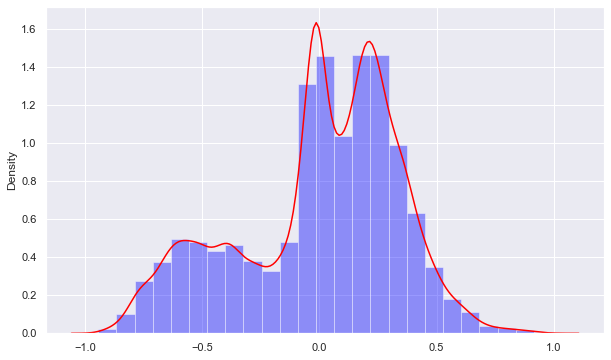

In [138]:
tester.error_vis(X_data)

# Finding Error and why it happens

In [139]:
rf_err = rf_2
rf_err.fit(X_data,np.array(y).ravel())

RandomForestClassifier(max_depth=18, min_samples_split=15, n_estimators=50,
                       random_state=1)

In [140]:
error_df = pd.DataFrame()
error_df = pd.concat((pd.DataFrame(np.array(y).ravel()), pd.DataFrame(rf_err.predict_proba(X_data))), axis=1)
error_df['prediction'] = rf_err.predict(X_data)
error_df.columns = ['True Value', 'P: Broke', 'P: Works', 'Prediction']

In [141]:
error_df['Correct?'] = (error_df['Prediction'] == error_df['True Value'])
error_df['Percent Wrong'] = np.array(y).ravel() - rf_err.predict_proba(X_data)[:,1]
error_df['Percent Wrong'] = error_df['Percent Wrong'].map(abs)*100


## Creating New Dataframes of error

In [142]:
correct_guesses = error_df.loc[(error_df['Percent Wrong'] < 50)].sort_values('Percent Wrong', ascending=True)
incorrect_guesses = error_df.loc[(error_df['Percent Wrong'] >= 50)]

correct_indexes = correct_guesses.index
incorrect_indexes = incorrect_guesses.index

In [143]:
false_positives = error_df.loc[(error_df['Percent Wrong'] >= 50) & (error_df['Prediction'] == 1)]
false_negatives = error_df.loc[(error_df['Percent Wrong'] >= 50) & (error_df['Prediction'] == 0)]

In [144]:
error_df.sort_values('Percent Wrong', ascending= False)

,True Value,P: Broke,P: Works,Prediction,Correct?,Percent Wrong
24504,1,0.992309,0.007691,0,False,99.230859
7468,1,0.985015,0.014985,0,False,98.501502
26905,1,0.965415,0.034585,0,False,96.541520
56876,1,0.964576,0.035424,0,False,96.457556
42785,1,0.945122,0.054878,0,False,94.512231
...,...,...,...,...,...,...
49090,0,1.000000,0.000000,0,True,0.000000
52382,0,1.000000,0.000000,0,True,0.000000
23492,0,1.000000,0.000000,0,True,0.000000
26145,0,1.000000,0.000000,0,True,0.000000


In [145]:
incorrect_indexes
total = pd.concat((X_data,y), axis=1)
incorrect_total = total.drop(index = correct_indexes)
incorrect_total.corr()['status_group'].sort_values(ascending=False)

status_group                          1.000000
waterpoint_type_other                 0.263943
extraction_type_group_other           0.243650
age                                   0.238863
quantity_dry                          0.219750
                                        ...   
waterpoint_type_communal standpipe   -0.096573
waterpoint_type_hand pump            -0.099197
payment_type_per bucket              -0.101446
quantity_enough                      -0.175665
construction_year                    -0.240848
Name: status_group, Length: 92, dtype: float64

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


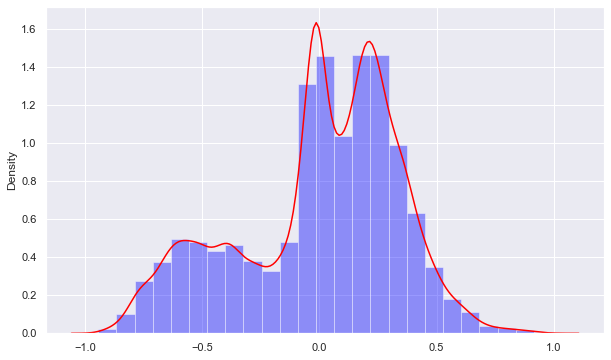

In [146]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.distplot((np.array(y).ravel() - rf_2.predict_proba(X_data)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'});

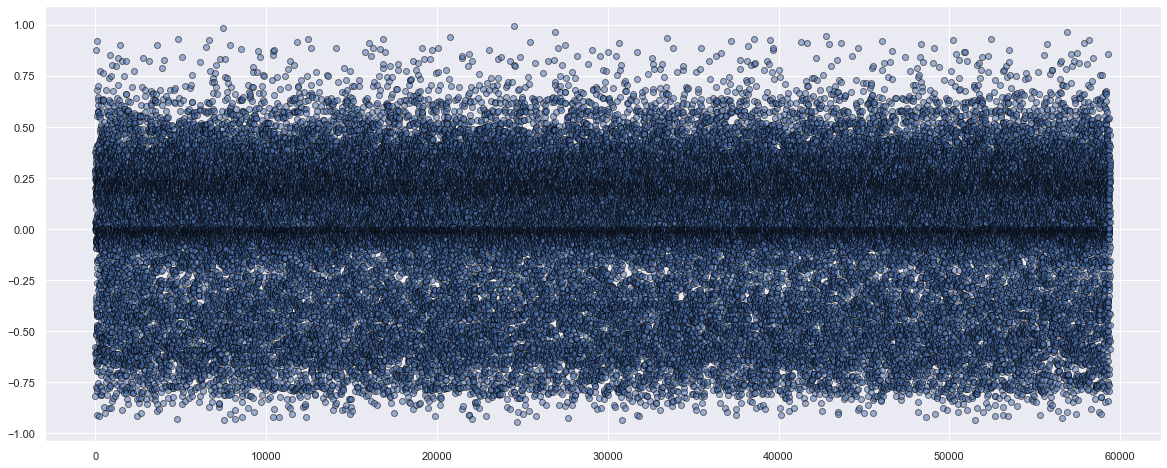

In [147]:
plt.figure(figsize=(20,8))
plt.scatter(list(range(len(y))), np.array(y).ravel() - rf_2.predict_proba(X_data)[:,1], alpha=.5, edgecolor='black' );

In [148]:
X_graph = X_clean.loc[X['longitude'] != 0]
#X_clean.loc[X_clean['gps_height'] == 0]['region'].value_counts()

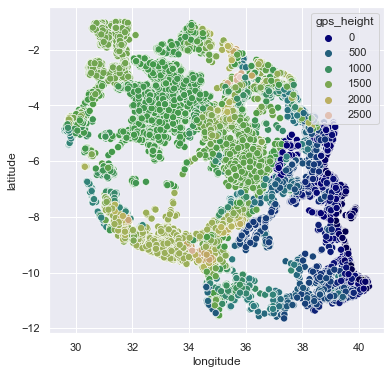

In [149]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data = X_graph, y = 'latitude', x = 'longitude', hue='gps_height', palette = 'gist_earth', s=50);

### Class Model

In [150]:
# class Model:
    
#     def __init__(self, model, X_val, y_val):
#         self.model = model
#         self.y = np.array(y).ravel()
#         self.columns = ['f1 score', 'accuracy_score', 'Notes']
#         self.df = pd.DataFrame(columns = self.columns)
#         self.X_val
        
#     def model_history(self, X_train, notes, model=None, y_train=None):
#         if not model:
#             model = self.model
#         if not y:
#             y = self.y
        
#         model.fit(X_train, y_train)
#         f1score = f1_score(y, model.predict(X_va))
#         accuracyscore = accuracy_score(y, model.predict(X))
#         frame = pd.DataFrame([[f1score, accuracyscore, notes]], columns=self.columns)
#         self.df = self.df.append(frame).reset_index(drop=True)
#         self.df = self.df.sort_values('f1 score', ascending=False)
#         return f1score, accuracyscore

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


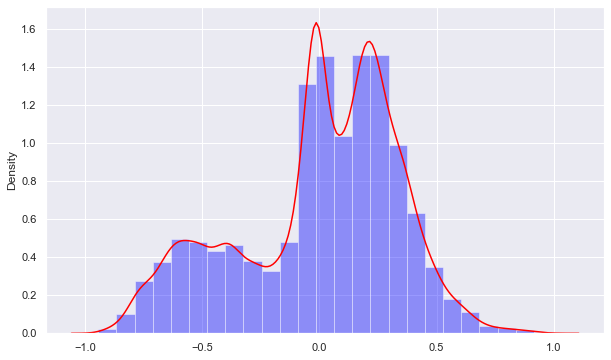

In [151]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.distplot((np.array(y).ravel() - rf_2.predict_proba(X_data)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'});

In [46]:
incorrect_indexes
total = pd.concat((X_data,y), axis=1)
incorrect_total = total.drop(index = correct_indexes)
incorrect_total.corr()['status_group'].sort_values(ascending=False).head(30)

status_group                                   1.000000
waterpoint_type_other                          0.263943
extraction_type_group_other                    0.243650
age                                            0.238863
quantity_dry                                   0.219750
waterpoint_type_communal standpipe multiple    0.178515
payment_type_never pay                         0.133113
installer_RWE                                  0.120786
installer_Government                           0.119108
basin_Lake Rukwa                               0.112566
quantity_seasonal                              0.110702
installer_KKKT                                 0.105194
quantity_unknown                               0.096227
source_type_river/lake                         0.095598
region_Mbeya                                   0.087701
water_quality_unknown                          0.078997
water_quality_coloured                         0.060002
region_Mara                                    0

In [47]:
logr = LogisticRegression(max_iter=500)

In [48]:
def get_redundant_pairs(X_nums_scaled):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = X_nums_scaled.columns
    for i in range(0, X_nums_scaled.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(X_nums_scaled, n=5):
    au_corr = X_nums_scaled.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X_nums_scaled)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
display(get_top_abs_correlations(X_nums_scaled, 10))

Top Absolute Correlations


construction_year  age                  0.995631
gps_height         population           0.144680
date_recorded      population           0.131747
                   age                  0.130990
                   gps_height           0.065241
gps_height         age                  0.044187
                   construction_year    0.038394
date_recorded      construction_year    0.037849
population         age                  0.020678
amount_tsh         population           0.016288
dtype: float64

In [49]:
X_interactions=X_data.copy()

In [50]:
X_interactions

,amount_tsh,date_recorded,gps_height,population,construction_year,age,installer_Commu,installer_DANIDA,installer_DWE,installer_Government,installer_KKKT,installer_Other,installer_RWE,installer_Unknown,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1.895665,-0.961322,0.485487,-0.150399,0.105584,-0.194575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.105970,1.124729,0.501776,0.212290,1.186187,-1.071715,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.097630,1.124729,-0.788697,0.148660,1.087950,-0.974255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.105970,1.124729,-1.554293,-0.258570,-1.171491,1.267325,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.105970,-0.961322,0.594082,-0.381587,0.203821,-0.292035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [51]:
X_interactions['gps_height*population']= X_interactions['gps_height']*X_interactions['population']
X_interactions['date_recorded*population']=X_interactions['date_recorded']*X_interactions['population']

In [52]:
tester.model_history(X_interactions, notes='Added two most relavant numeric interactions')

(array([0.83160298, 0.83017245, 0.83020166]),
 array([0.80257576, 0.80055556, 0.80055556]))

In [53]:
tester.df

,f1 score,accuracy_score,Notes
0,0.831652,0.801650,Base model with no feature engineering
1,0.830659,0.801229,Added two most relavant numeric interactions


In [54]:
def get_redundant_pairs(X_data):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = X_data.columns
    for i in range(0, X_data.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(X_data, n=5):
    au_corr = X_data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X_data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
display(get_top_abs_correlations(X_data, 50))

Top Absolute Correlations


construction_year                   age                                   0.995631
water_quality_salty                 water_quality_soft                    0.726073
extraction_type_group_other         waterpoint_type_other                 0.708461
installer_DWE                       installer_Other                       0.702776
quantity_enough                     quantity_insufficient                 0.657743
extraction_type_group_gravity       source_type_spring                    0.646092
source_type_shallow well            waterpoint_type_hand pump             0.645075
basin_Lake Tanganyika               region_Kigoma                         0.640182
basin_Pangani                       region_Kilimanjaro                    0.639787
extraction_type_group_gravity       waterpoint_type_communal standpipe    0.627240
waterpoint_type_communal standpipe  waterpoint_type_hand pump             0.620821
extraction_type_group_nira/tanira   waterpoint_type_hand pump             0.609153
basi

In [55]:
from category_encoders import *

In [101]:
X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(X_clean, y, random_state=1)
X_train_cats, X_train_nums = cleaning(X_train_te)
X_test_cats, X_test_nums = cleaning(X_test_te)

X_train_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)
X_test_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)


In [102]:
te = TargetEncoder()
te.fit(X_train_cats, y_train_te)
X_cats_train_te = pd.DataFrame(te.transform(X_train_cats), columns =X_train_cats.columns)
X_cats_test_te = pd.DataFrame(te.transform(X_test_cats),columns =X_train_cats.columns)

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [103]:
ss = StandardScaler()
ss.fit(X_train_nums)
X_nums_train_scaled = pd.DataFrame(ss.transform(X_train_nums), columns = X_train_nums.columns)
X_nums_test_scaled = pd.DataFrame(ss.transform(X_test_nums), columns = X_test_nums.columns)

In [109]:
X_train_te = pd.concat((X_nums_train_scaled, X_cats_train_te), axis=1)
X_test_te = pd.concat((X_nums_test_scaled, X_cats_test_te), axis=1)


In [108]:
X_clean.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_group    0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type          0
age                      0
dtype: int64

In [87]:
X_test_te= X_test_te.dropna()
X_train_te = X_train_te.dropna()

In [88]:
X_train_te.isna().sum()

amount_tsh               0
gps_height               0
num_private              0
region_code              0
district_code            0
population               0
construction_year        0
date_recorded            0
funder                   0
installer                0
wpt_name                 0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [89]:
rf_2.fit(X_train_te, y_train_te)

ValueError: Found input variables with inconsistent numbers of samples: [33407, 44550]

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_df, y_train) 
print(pd.Series(y_train_resampled).value_counts())